# Case Study 2:

##                     ThinkyouhaveSolvedQuestionAnswering?              TryARC,theAI2ReasoningChallenge 

### 1. Business Problem

#### 1.1 Description

The ARC dataset contains 7,787 genuine grade-school level, multiple-choice science questions, assembled to encourage research in advanced question-answering. The dataset is partitioned into a Challenge Set and an Easy Set, where the former contains only questions answered incorrectly by both a retrieval-based algorithm and a word co-occurrence algorithm

Problem Statement :
                Need to solve the Question Answering based on the ARC Corpus given

## 2. Machine Learning Probelm

### 2.1 Data

#### 2.1.1 Data Overview

    1)This data set consists of 7,787 science exam questions
    2)The questions are sorted into a Challenge Set of 2,590 “hard” questions and an Easy Set of 5,197 questions
    3)Each set is provided in two formats, CSV and JSON

JSONL Structure:

            The JSONL files contain the same questions split into the “stem” of the question (the question text) and then the various answer “choices” and their corresponding labels (A, B, C, D). The questionID is also included.
            
            
            {"id":"MCAS_2000_4_6","question":{"stem":"Which technology was developed most recently?","choices":[{"text":"cellular telephone","label":"A"},{"text":"television","label":"B"},{"text":"refrigerator","label":"C"},{"text":"airplane","label":"D"}]},"answerKey":"A"}

    id - a unique identifier for the question (our own numbering)
    question
        stem - the question text
        choices - the answer choices
            label - the answer label ("A", "B", "C", "D")
                text - the text associated with the answer label
        answerKey - the the correct answer option


CSV Structure

    Comma-delimited (CSV) columns:

        questionID - a unique identifier for the question (our own numbering)
        originalQuestionID - the question number on the test
        totalPossiblePoint - how many points the question is worth when scoring
        AnswerKey - the correct answer option
        isMultipleChoiceQuestion - 1 = multiple choice, 0 = other
        includesDiagram - 1 = includes diagram, 0 = other
        examName - the source of the exam
        schoolGrade - grade level
        year - publication year of the exam
        question - the text of the question itself
        subject - the general question topic
        category - Test, Train, or Dev

#### 2.1.2 Example Data point

Mercury_7057260,7057260,1,C,1,0,Mercury,8,2015,A student hypothesizes that algae are producers. Which question will best help the student determine if this is correct? (A) Do algae consume other organisms? (B) Which organisms consume algae? (C) Do algae use sunlight to make food? (D) Could an ecosystem survive without algae?,,Dev

ACTAAP_2014_7_6,6,1,A,1,0,ACTAAP,7,2014,Soccer players use their muscle systems to kick a ball into a goal. What organ system coordinates the muscles? (A) The nervous system (B) The endocrine system (C) The respiratory system (D) The circulatory system,,Dev

#### 2.1.3 Train , CV and Test

    Challenge Train: 1,119
    Challenge Dev: 299
    Challenge Test: 1,172

    Easy Train: 2,251
    Easy Dev: 570
    Easy Test: 2,376

#### 2.1.4 Data Corpus
    The ARC Corpus, containing 14M science-related sentences with knowledge relevantto ARC.

#### 2.1.5 Task

    Perform any of the neural model to cross the score of 67%

# 3. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer


## 3.1 Reading data and basic stats

In [42]:
Challenge_Train_df = pd.read_csv("ARC-V1-Feb2018-2/ARC-Challenge/ARC-Challenge-Train.csv")

print("Number of data points:",Challenge_Train_df.shape[0])

Number of data points: 1119


In [4]:
Challenge_Train_df.head()

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category
0,Mercury_SC_415702,415702,1,A,1,0,Mercury,3,2015,George wants to warm his hands quickly by rubb...,NaN,Train
1,MCAS_2009_5_6516,6516,1,B,1,0,MCAS,5,2009,Which of the following statements best explain...,NaN,Train
2,Mercury_7233695,7233695,1,B,1,0,Mercury,9,2015,A fold observed in layers of sedimentary rock ...,NaN,Train
3,Mercury_7041615,7041615,1,D,1,0,Mercury,8,2015,Which of these do scientists offer as the most...,NaN,Train
4,Mercury_7041860,7041860,1,B,1,0,Mercury,8,2015,A boat is acted on by a river current flowing ...,NaN,Train


In [5]:
Challenge_Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 12 columns):
questionID                  1119 non-null object
originalQuestionID          1119 non-null object
totalPossiblePoint          1119 non-null int64
AnswerKey                   1119 non-null object
isMultipleChoiceQuestion    1119 non-null int64
includesDiagram             1119 non-null int64
examName                    1119 non-null object
schoolGrade                 1119 non-null int64
year                        1119 non-null object
question                    1119 non-null object
subject                     0 non-null float64
category                    1119 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 105.0+ KB


### Observation:
    1)There are 12 columns and 1119 rows
    2)The subject column contains no value

## 3.2.1 Distribution of data points among output classes

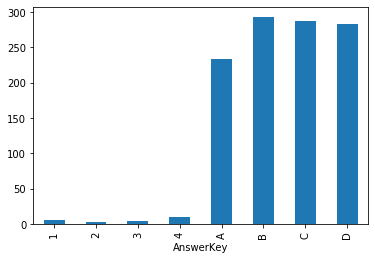

In [6]:
Challenge_Train_df.groupby("AnswerKey")['questionID'].count().plot.bar()

In [7]:
Challenge_Train_df.groupby("AnswerKey")['questionID'].count()

AnswerKey
1      6
2      3
3      4
4     10
A    233
B    293
C    287
D    283
Name: questionID, dtype: int64

## Observation:
    1)Most of the question answers are A,B,C,D
    2)There are some question with answers are 1,2,3,4

## 3.2.2 Checking for Duplicates

In [8]:

# Select all duplicate rows based on multiple column names in list
duplicateRowsDF = Challenge_Train_df[Challenge_Train_df.duplicated(['questionID','question'])]
print("Duplicate Rows based on 2 columns are:", duplicateRowsDF, sep='\n')


Duplicate Rows based on 2 columns are:
Empty DataFrame
Columns: [questionID, originalQuestionID, totalPossiblePoint, AnswerKey, isMultipleChoiceQuestion, includesDiagram, examName, schoolGrade, year, question, subject, category]
Index: []


### Observation:
    There is no dublicate question

## 3.2.3 Checking School Grade Question

In [9]:
Challenge_Train_df.groupby("schoolGrade")['questionID'].count()

schoolGrade
3     47
4    105
5    210
6     27
7    175
8    456
9     99
Name: questionID, dtype: int64

### Observation:
    1) Questions for grade 8 is high 456
    2) Questions for grade 6 is low 27

## 3.2.4 Checking MultiChoice Question

In [10]:
Challenge_Train_df.groupby("isMultipleChoiceQuestion")['questionID'].count()

isMultipleChoiceQuestion
1    1119
Name: questionID, dtype: int64

### Observation:
    Every question has only 1 answer

## 3.2.4 Checking Exam Names

In [11]:
Challenge_Train_df.groupby("examName")['questionID'].count()


examName
ACTAAP                                                   39
AIMS                                                      6
Alaska Department of Education & Early Development        7
Alaska Department of Education and Early Development      6
Alaska Dept. of Education & Early Development             8
California Standards Test                                 5
California Standards Test - Science                       8
FCAT                                                      1
Louisiana Educational Assessment Program                 14
MCAS                                                     97
MEA                                                      16
MEAP                                                      6
MSA                                                      14
Maryland School Assessment                               13
Maryland School Assessment - Science                     19
Mercury                                                 736
NAEP                           

### Observation:

    1)Mercury exams has high Questions
    2)WASL & FCAT exams has low  Questions

# PreProcessing

In [2]:

def data_from_json(filename):
    """Loads JSON data from filename and returns"""
    dataset=[]
    i=0
    with open(filename, 'r', encoding="utf8") as f:
            for l in f.readlines():
                ll = json.loads(l.strip())
                dataset.append(ll)
    return dataset

In [3]:

def write_to_file(out_file, line):
    """Take a line and file as input, encdes the line to utf-8 and then writes that line to the file"""
    out_file.write(line + '\n')

In [4]:
def tokenize(sequence, do_lowercase):
    """Tokenizes the input sequence using nltk's word_tokenize function, replaces two single quotes with a double quote"""

    tokens = [token.replace("``", '"').replace("''", '"').lower() for token in nltk.word_tokenize(sequence)]
    return tokens


# Tokenize the corpus

In [ ]:
#tokenize the text corpus and loading it into context.txt
context_tokens=[]
charloc2wordloc=dict()
examples=[]
filepath = 'D:\Ai_Course_Doc\case_1\dataset\ARC_Corpus.txt'
filewritepath = 'D:\Ai_Course_Doc\case_1\dataset\context.txt'

with open(filepath,'r', encoding="utf8") as fp:
    line = fp.readline()
    while line:
        # use realine() to read next line
        line = fp.readline()
        context=line
        context = context.replace("''", '" ')
        context = context.replace("``", '" ')
        context_tokens = tokenize(context, False )  # list of strings (lowercase)
        examples.append(' '.join(context_tokens))
        break
fp.close()

with open(filewritepath, 'w', encoding='utf-8') as context_file:
    for tokens in examples:
        write_to_file(context_file, tokens)
    context_file.close()
                        


# Tokenize the  question,answer and choices

In [12]:
#tokenize the question,answer and choices and loading it into as file 

question_tokens=[]
ans_tokens=[]
choices_tokens=[]
ans_word_tokens=[]

def preprocess_and_write(dataset, tier):
    tt=0
    squad_version=1.1
    out_dir ="D:\Ai_Course_Doc\case_1\dataset"
    for qn in dataset:

    # read the question text and tokenize
        question = qn['question']['stem'] # string
        question_tokens.append(tokenize(question, True))

        text_list=""
        ans_text=""
        for ans in qn['question']['choices']: 
          
            text_list+=str(tokenize(ans['text'],True))+str(' ')
            if ans['label']==qn['answerKey']:
                ans_text=ans['text']

        ans_tokens.append(qn['answerKey'])
        ans_word_tokens.append(ans_text)
        choices_tokens.append(text_list)
        
    with open(os.path.join(out_dir, tier + '-v{}.cha_question'.format(squad_version)), 'w', encoding='utf-8') as question_file,\
        open(os.path.join(out_dir, tier + '-v{}.cha_choices'.format(squad_version)), 'w', encoding='utf-8') as choices_file,\
        open(os.path.join(out_dir, tier + '-v{}.cha_answer'.format(squad_version)), 'w', encoding='utf-8') as ans_text_file,\
        open(os.path.join(out_dir, tier + '-v{}.cha_word_answer'.format(squad_version)), 'w', encoding='utf-8') as ans_word_text_file:
        
        for i in range(len(question_tokens)):
            write_to_file(question_file, str(question_tokens[i]))
            write_to_file(ans_text_file, str(ans_tokens[i]))
            write_to_file(choices_file, str(choices_tokens[i]))
            write_to_file(ans_word_text_file, str(ans_word_tokens[i]))



In [21]:
import json

data_dir ="D:\Ai_Course_Doc\case_1\ARC-V1-Feb2018-2\ARC-Challenge"

squad_version=1.1

train_filename = "ARC-Challenge-Train.jsonl".format(squad_version)

train_data = data_from_json(os.path.join(data_dir, train_filename))

preprocess_and_write(train_data, 'train')

In [9]:
train_data[0]

{'id': 'Mercury_SC_415702',
 'question': {'stem': 'George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?',
  'choices': [{'text': 'dry palms', 'label': 'A'},
   {'text': 'wet palms', 'label': 'B'},
   {'text': 'palms covered with oil', 'label': 'C'},
   {'text': 'palms covered with lotion', 'label': 'D'}]},
 'answerKey': 'A'}

In [13]:
import json
data_dir ="D:\Ai_Course_Doc\case_1\ARC-V1-Feb2018-2\ARC-Challenge"

squad_version=1.1

dev_filename = "ARC-Challenge-Dev.jsonl".format(squad_version)

dev_data = data_from_json(os.path.join(data_dir, dev_filename))

preprocess_and_write(dev_data, 'dev')

In [36]:
data_dir ="D:\Ai_Course_Doc\case_1\ARC-V1-Feb2018-2\ARC-Challenge"

squad_version=1.1

test_filename = "ARC-Challenge-Test.jsonl".format(squad_version)

test_data = data_from_json(os.path.join(data_dir, test_filename))

preprocess_and_write(test_data, 'test')

In [34]:
len(test_data)

1172

# Finding the intrection words between the Question and Context  

In [10]:
contex_data = pd.read_csv('D:\Ai_Course_Doc\case_1\dataset\context.txt', header = None,delimiter= '\n',names=["contex"])

In [11]:
contex_data.head()

,contex
0,Paleoceanography 8 2 193 208
1,Of course for many in the media hydrogen sulph...
2,The same problems apply with wolf domestic dog...
3,taking stock of delightful days
4,The an tlu opologist and the ethnologist find ...


In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [ ]:
#The intersection words between the question and context line should be minimum 3

contex_line=[]
data_dir ="/content/drive/My Drive/case_study_1"
out_dir ="/content/drive/My Drive/case_study_1/ch_files"

squad_version=1.1

train_filename = "ARC-Challenge-Train.jsonl".format(squad_version)

train_data = data_from_json(os.path.join(data_dir, train_filename))
i=0
with open(os.path.join(out_dir, 'train' + '-v{}.cha_context'.format(squad_version)), 'w', encoding='utf-8') as context_file:
    for qn in train_data:
        

        # read the question text and tokenize
        question = qn['question']['stem'] # string
        document_1_words=[word for word in tokenize(question, True) if not word in stop_words]
        document_1_words=[re.sub('[^a-zA-Z0-9]+','govind' , _) for _ in document_1_words]
        text_list=""
        for line in contex_data["contex"]:
            document_2_words = line.split() 
            common = set(document_1_words).intersection( set(document_2_words) )

            if(len(common)>3):
                text_list+=line+str(' ')
                
        if text_list.strip()=="":
            for line in contex_data["contex"]:
                document_2_words = line.split() 
                common = set(document_1_words).intersection( set(document_2_words) )

                if(len(common)>2):
                    text_list+=line+str(' ')
            

        write_to_file(context_file,text_list)
        

In [ ]:
#The intersection words between the question and context line should be minimum 3

contex_line=[]
data_dir ="/content/drive/My Drive/case_study_1"
out_dir ="/content/drive/My Drive/case_study_1/ch_files"

squad_version=1.1

train_filename = "ARC-Challenge-Dev.jsonl".format(squad_version)

train_data = data_from_json(os.path.join(data_dir, train_filename))
i=0
with open(os.path.join(out_dir, 'dev' + '-v{}.cha_context'.format(squad_version)), 'w', encoding='utf-8') as context_file:
    for qn in train_data:
        

        # read the question text and tokenize
        question = qn['question']['stem'] # string
        document_1_words=[word for word in tokenize(question, True) if not word in stop_words]
        document_1_words=[re.sub('[^a-zA-Z0-9]+','govind' , _) for _ in document_1_words]
        text_list=""
        for line in contex_data["contex"]:
            document_2_words = line.split() 
            common = set(document_1_words).intersection( set(document_2_words) )

            if(len(common)>3):
                text_list+=line+str(' ')
                
        if text_list.strip()=="":
            for line in contex_data["contex"]:
                document_2_words = line.split() 
                common = set(document_1_words).intersection( set(document_2_words) )

                if(len(common)>2):
                    text_list+=line+str(' ')
            

        write_to_file(context_file,text_list)
        

In [ ]:
#The intersection words between the question and context line should be minimum 3

contex_line=[]
data_dir ="/content/drive/My Drive/case_study_1"
out_dir ="/content/drive/My Drive/case_study_1/ch_files"

squad_version=1.1

train_filename = "ARC-Challenge-Test.jsonl".format(squad_version)

train_data = data_from_json(os.path.join(data_dir, train_filename))
i=0
with open(os.path.join(out_dir, 'test' + '-v{}.cha_context'.format(squad_version)), 'w', encoding='utf-8') as context_file:
    for qn in train_data:
        

        # read the question text and tokenize
        question = qn['question']['stem'] # string
        document_1_words=[word for word in tokenize(question, True) if not word in stop_words]
        document_1_words=[re.sub('[^a-zA-Z0-9]+',' ' , _) for _ in document_1_words]
        text_list=""
        for line in contex_data["contex"]:
            document_2_words = line.split() 
            common = set(document_1_words).intersection( set(document_2_words) )

            if(len(common)>3):
                text_list+=line+str(' ')
                
        if text_list.strip()=="":
            for line in contex_data["contex"]:
                document_2_words = line.split() 
                common = set(document_1_words).intersection( set(document_2_words) )

                if(len(common)>2):
                    text_list+=line+str(' ')
            

        write_to_file(context_file,text_list)
        

# Finding the matching between the answer and preprocessed context for each question 

In [15]:
contex_data=[]
with open('D:/Ai_Course_Doc/case_1/drive-download-20200107T165248Z-001/ch_files/train-v1.1.cha_context', 'r', encoding='utf-8') as f:
    for line in f.read().split("\n"):
        contex_data.append(line)
    f.close

In [20]:
len(contex_data)

1119

In [24]:
answer_data=[]
with open('D:/Ai_Course_Doc/case_1/dataset/train-v1.1.cha_word_answer', 'r', encoding='utf-8') as f:
    for line in f.read().split("\n"):
        answer_data.append(line.strip())
    f.close

In [25]:
len(answer_data)

1119

In [26]:
ans_word=0
con_word=0
empty_contex=0
for answer,contex in zip(answer_data,contex_data):
    if len(contex) <3:
        empty_contex=empty_contex+1
    for contex_line in contex.split(','):
        if answer in contex_line:
            ans_word=ans_word+1
            break


In [27]:
print('answer in given contex ',ans_word/len(answer),'%')
print('empty contex ',empty_contex/len(answer),'%')

answer in given contex  9.363636363636363 %
empty contex  3.5454545454545454 %


Observation :

1)There are 9.36% of exact answers are in the preprocesed row context in itself

2)There are 3.54% of contex are empty

In [44]:
import random

Random_acc=0
total_count=0
with open('D:/Ai_Course_Doc/case_1/dataset/train-v1.1.cha_answer', 'r', encoding='utf-8') as sf:
    for line in sf:
        random_choice=random.choice(['A', 'B', 'C', 'D'])
        line=line.strip()
        if (line=='A' or line=='1') and random_choice=='A':
            Random_acc=Random_acc+1
        if (line=='B' or line=='2') and  random_choice=='B':
            Random_acc=Random_acc+1
        if (line=='C' or line=='3' ) and  random_choice=='C':
            Random_acc=Random_acc+1
        if (line=='D' or line=='4') and  random_choice=='D':
            Random_acc=Random_acc+1
        total_count=total_count+1

print("The Randome model predict acc of ",Random_acc/total_count,"%"  )

The Randome model predict acc of  0.21894548704200179 %


# One Hot Encoding for the Answerkeys

In [44]:
ans_one_hot=[]
cout_A=0
cout_B=0
cout_C=0
cout_D=0
cout_E=0
total=0
for ans in Challenge_Train_df['AnswerKey'].values:
    if ans=='A' or ans=='1':
        ans_one_hot.append([1,0,0,0,0])
        cout_A=cout_A+1
    if ans=='B' or ans=='2':
        ans_one_hot.append([0,1,0,0,0])
        cout_B=cout_B+1
    if ans=='C' or ans=='3':
        ans_one_hot.append([0,0,1,0,0])
        cout_C=cout_C+1
    if ans=='D' or ans=='4':
        ans_one_hot.append([0,0,0,1,0])
        cout_D=cout_D+1
    if ans=='E':
        ans_one_hot.append([0,0,0,0,1])
        cout_E=cout_E+1
        
    total=total+1
    

In [41]:
ans_one_hot[1]

[0, 1, 0, 0, 0]

In [45]:
print("A =",cout_A/total)
print("B =",cout_B/total)
print("C =",cout_C/total)
print("D =",cout_D/total)
print("E =",cout_E/total)


A = 0.21358355674709562
B = 0.2645218945487042
C = 0.26005361930294907
D = 0.26184092940125114
E = 0.0


In [41]:
print("A =",cout_A/total)
print("B =",cout_B/total)
print("C =",cout_C/total)
print("D =",cout_D/total)
print("E =",cout_E/total)


A = 0.24344735673034207
B = 0.2612172367836517
C = 0.2567747667703243
D = 0.23767214571301643
E = 0.000888494002665482


In [39]:
tt=pd.DataFrame([ans_one_hot])

In [46]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Challenge_Train_df['AnswerKey'].values),
                                                 Challenge_Train_df['AnswerKey'].values)

In [47]:
class_weights

array([23.3125    , 46.625     , 34.96875   , 13.9875    ,  0.60032189,
        0.47738908,  0.48736934,  0.49425795])

In [3]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [4]:
len_th=[]
word_no=0
k=0

with open('D:/Ai_Course_Doc/case_1/drive-download-20200107T165248Z-001/ch_files/train-v1.1.cha_context', 'r', encoding='utf-8') as cf:
    for line in cf:
        word_no=0
        for word in line.split(' '):
            if word.lower() not in stopwords:
                  word_no=word_no+1
        len_th.append(word_no)

In [5]:
for i in range(0,101,25):
    print('i->',i,' value ',np.percentile(len_th, i))

i-> 0  value  1.0
i-> 25  value  141.5
i-> 50  value  604.0
i-> 75  value  2247.5
i-> 100  value  850181.0


In [24]:
len_th=[]
word_no=0
k=0

with open('D:/Ai_Course_Doc/case_1/dataset/train-v1.1.cha_choices', 'r', encoding='utf-8') as cf:
    for line in cf:
        word_no=0
        for word in line.split('] ['):
            word=word.replace("'",'').replace("[",'').replace("]",'')
            for i in word.split(','):
                    word_no=word_no+1
        len_th.append(word_no)

In [25]:
for i in range(0,101,25):
    print('i->',i,' value ',np.percentile(len_th, i))

i-> 0  value  4.0
i-> 25  value  8.0
i-> 50  value  20.0
i-> 75  value  31.0
i-> 100  value  124.0


In [8]:
len_th=[]
word_no=0
k=0

with open('D:/Ai_Course_Doc/case_1/dataset/train-v1.1.cha_question', 'r', encoding='utf-8') as cf:
    for line in cf:
        word_no=0
        for word in line.split(','):
              word=word.replace("'",'').replace("?",'')
      #for i in word.split(','):
              if word.lower() not in stopwords:
                word_no=word_no+1
        len_th.append(word_no)

In [9]:
for i in range(0,101,25):
    print('i->',i,' value ',np.percentile(len_th, i))

i-> 0  value  5.0
i-> 25  value  12.0
i-> 50  value  18.0
i-> 75  value  29.0
i-> 100  value  111.0
